In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmcrameri import cm
import matplotlib.colors as colors

In [2]:
side_events_all = pd.read_csv("../all_side_events_complete_lang.csv",encoding = "utf-8")
side_events_all[["COP","Num"]] = side_events_all["SE_Code"].str.split("-",expand=True)
#JT_events = pd.read_csv("Events_JT.csv",encoding = "utf-8")
#JT_events

In [3]:
for event_num in np.arange(20)+9:
    event_phrase = "COP"+ str(event_num).zfill(2)
    this_COP = side_events_all[side_events_all['SE_Code'].str.contains(event_phrase)]
    this_COP_collab = this_COP[this_COP["Organizer_Count"]>1]
    this_COP_data = pd.DataFrame(data={"all_events":len(this_COP),"Co-hosted":len(this_COP_collab)},index=[event_phrase])
    if event_num == 9:
        all_COP_data = this_COP_data
    else:
        all_COP_data = pd.concat([all_COP_data,this_COP_data])
all_COP_data["Individual"] = all_COP_data["all_events"] - all_COP_data["Co-hosted"]
all_COP_data.to_csv("event_hosts.csv")

In [3]:
match_ngo = pd.read_excel("../orgs/org_list_ngo_check.xlsx",sheet_name="match")
ngo_list = pd.read_csv("../orgs/org_list_ngo.csv")
igo_list = pd.read_excel("../orgs/org_list_igo.xlsx")
party_list = pd.read_csv("../orgs/org_list_party.csv")
un_list = pd.read_excel("../orgs/org_list_un.xlsx")
un_list = un_list[un_list["Type"].isna()==False]
org_mismatch = pd.read_excel("affiliation/event_affiliation_JT_mismatch.xlsx")
org_mismatch

,original_name,matched_name,Unnamed: 2
0,WMO/UNEP Intergovernmental Panel on Climate Ch...,United Nations,NaN
1,Economic Commission for Africa (ECA),United Nations,NaN
2,United Nations Entity for Gender Equality and ...,United Nations,NaN
3,Southern African Faith Communities Environment...,Southern African Faith Communities' Environmen...,NaN
4,Lund University,Lund University (LU),NaN
...,...,...,...
149,International Pharmaceutical Students Federati...,International Pharmaceutical Students' Federat...,NaN
150,Lloyds Register (LR),NaN,NaN
151,Le Centre québécois du droit de lenvironnement...,Le Centre québécois du droit de l'environnemen...,NaN
152,Derecho Ambiente y Recursos Naturales (DAR),"Derecho, Ambiente y Recursos Naturales (DAR) (...",NaN


In [10]:
for ind in JT_events.index:
    org_names = JT_events.loc[ind,"Organizer_Affiliation"]
    org_names = org_names.replace("', '","***").replace(', "',"***").replace('", ',"***")
    org_names = org_names.replace("[","").replace("]","").replace("'","").replace('"',"")
    org_names_list = org_names.split("***")
    event_data = pd.DataFrame(data={"Org":org_names_list}).set_index("Org")
    for org in org_names_list:
        org = org.replace("['","").replace("']","").replace("'","").replace('"',"")
        if org in list(org_mismatch["original_name"]): # REPLACE NAME IF IT'S WEIRD
            o = org_mismatch.query("original_name==@org")["matched_name"].iloc[0]
        else:
            o = org
            
        event_data.loc[org,"Weight"] = 1/(len(org_names_list))
        if o in list(party_list["party"]): # ORGANZIED BY A PARTY
            org_type = party_list.query("party==@o")["type"]
            event_data.loc[org,"Org_Type"] = "Party"
            event_data.loc[org,"Country"] = o
            event_data.loc[org,"Country_Type"] = org_type.iloc[0]
        elif o in list(ngo_list["Organization"]): # ORGANIZED BY A NGO
            #matched_name = match_ngo.query("nominator==@o")["matched_name"].iloc[0]
            org_type = ngo_list.query("Organization==@o")["Constituency"].iloc[0]
            if org_type in ["Constituency - Environmental CAN","Constituency - Environmental CJN"]:
                org_type = "Constituency - Environmental"
            elif type(org_type) == float or org_type in ['Constituency - Farmers','Constituency - Local government and Municipal authorities','Constituency - Trade Unions']: 
                org_type = "Constituency - Others"
            country_aff = ngo_list.query("Organization==@o")["Country"].iloc[0]
            event_data.loc[org,"Org_Type"] = org_type
            event_data.loc[org,"Country"] = country_aff
            if country_aff in list(party_list["party"]):
                country_type = party_list.query("party==@country_aff")["type"].iloc[0]
                event_data.loc[org,"Country_Type"] = country_type
        elif o in list(igo_list["Organization"]): # ORGANIZED BY IGO
            country_aff = igo_list.query("Organization==@o")["Country"].iloc[0]
            event_data.loc[org,"Org_Type"] = "IGO"
            event_data.loc[org,"Country"] = country_aff
            if country_aff in list(party_list["party"]):
                country_type = party_list.query("party==@country_aff")["type"].iloc[0]
                event_data.loc[org,"Country_Type"] = country_type
        elif o in list(un_list["Organization"]): # ORGANIZED BY THE UN
            event_data.loc[org,"Org_Type"] = "UN"
            event_data.loc[org,"Country"] = "International"
            event_data.loc[org,"Country_Type"] = "International"
    event_data = event_data.reset_index()
    event_data["SE_Code"] = JT_events.loc[ind,"SE_Code"]
    if ind == JT_events.index[0]:
        event_data_JT = event_data
    else:
        event_data_JT = pd.concat([event_data_JT,event_data])
event_data_JT = event_data_JT.set_index("SE_Code").reset_index()
event_data_JT["Org_Type"] = event_data_JT["Org_Type"].fillna("No match")
event_data_JT["Country_Type"] = event_data_JT["Country_Type"].fillna("No match")

event_data_JT.to_excel("affiliation/event_affiliation_JT.xlsx", index=False)
event_data_JT

,SE_Code,Org,Weight,Org_Type,Country,Country_Type
0,COP28-059,Eswatini,0.500000,Party,Eswatini,Non-Annex
1,COP28-059,Taiwan Institute for Sustainable Energy (TISE),0.500000,Constituency - Business and Industry,China,Non-Annex
2,COP28-108,United Nations University (UNU),0.333333,UN,International,International
3,COP28-108,WMO/UNEP Intergovernmental Panel on Climate Ch...,0.333333,UN,International,International
4,COP28-108,"United Nations Educational, Scientific and Cul...",0.333333,UN,International,International
...,...,...,...,...,...,...
929,COP19-188,Women Organizing for Change in Agriculture and...,1.000000,Constituency - Women and Gender,United States of America,Annex II
930,COP19-198,Women Organizing for Change in Agriculture and...,1.000000,Constituency - Women and Gender,United States of America,Annex II
931,COP17-140,Regional Community Forestry Training Center fo...,1.000000,IGO,Thailand,Non-Annex
932,COP13-118,ActionAid International Foundation,1.000000,Constituency - Environmental,South Africa,Non-Annex


In [11]:
for phrase in side_events_all["COP"].unique():
    mask = np.column_stack([side_events_all[col].str.contains(phrase, na=False) for col in side_events_all[["SE_Code"]]])
    year_se = side_events_all.loc[mask.any(axis=1)]
    num_se = len(year_se)

    mask2 = np.column_stack([event_data_JT[col].str.contains(phrase, na=False) for col in event_data_JT[["SE_Code"]]])
    year_se_JT = event_data_JT.loc[mask2.any(axis=1)]
    
    year_se_JT_group = year_se_JT.groupby("Org_Type").sum()[["Weight"]]
    #year_se_JT_group.loc["Remaining"] = num_se-year_se_JT_group["Weight"].sum()
    year_se_JT_group["Weight_Percent"] = year_se_JT_group["Weight"]/num_se*100
    year_se_JT_group["COP"] = phrase
    
    year_se_JT_group2 = year_se_JT.groupby("Country_Type").sum()[["Weight"]]
    #year_se_JT_group.loc["Remaining"] = num_se-year_se_JT_group["Weight"].sum()
    year_se_JT_group2["Weight_Percent"] = year_se_JT_group2["Weight"]/num_se*100
    year_se_JT_group2["COP"] = phrase
    
    if phrase == side_events_all["COP"].unique()[0]:
        JT_org_type = year_se_JT_group
        JT_country_type = year_se_JT_group2
    else:
        JT_org_type = pd.concat([JT_org_type,year_se_JT_group])
        JT_country_type = pd.concat([JT_country_type,year_se_JT_group2])
JT_org_type = JT_org_type.reset_index()
JT_country_type = JT_country_type.reset_index()
JT_org_type

,Org_Type,Weight,Weight_Percent,COP
0,Constituency - Business and Industry,8.333333,2.258356,COP28
1,Constituency - Environmental,21.564286,5.843980,COP28
2,Constituency - Indigenous peoples,0.200000,0.054201,COP28
3,Constituency - Others,4.400000,1.192412,COP28
4,Constituency - Research and independent,17.752381,4.810943,COP28
...,...,...,...,...
117,Constituency - Others,1.000000,0.943396,COP10
118,IGO,1.000000,0.943396,COP10
119,Constituency - Environmental,1.000000,0.877193,COP09
120,Constituency - Research and independent,1.000000,0.877193,COP09


### visualization

In [16]:
# pivoted JT events by country type
pivoted_data_country = JT_country_type.pivot(index='COP', columns='Country_Type', values='Weight')
pivoted_data_country = pivoted_data_country.fillna(0)
pivoted_data_country = pivoted_data_country[['Annex II','Annex I Only','Non-Annex','International','No match']]

# pivoted JT events by organization type
pivoted_data_org = JT_org_type.pivot(index='COP', columns='Org_Type', values='Weight')
pivoted_data_org = pivoted_data_org.fillna(0)
for col in pivoted_data_org.columns:
    pivoted_data_org = pivoted_data_org.rename(columns={col:col.replace("Constituency -","NGO").replace("and","&")})
    pivoted_data_org = pivoted_data_org.rename(columns={'NGO - Local government & Municipal authorities':'NGO - Local government'})

# summary of all side events and JT
side_events_all["Weight"]=1
side_events_sum = side_events_all.groupby("COP").sum()[["Weight"]]
side_events_sum_JT = JT_org_type.groupby("COP").sum()[["Weight"]]
side_events_sum_JT["Percent"] = side_events_sum_JT["Weight"]/side_events_sum["Weight"]*100


,all_events,Co-hosted,Individual
COP09,114,0,114
COP10,106,0,106
COP11,157,0,157
COP12,127,0,127
COP13,203,0,203
COP14,200,0,200
COP15,305,0,305
COP16,240,0,240
COP17,227,91,136
COP18,215,84,131


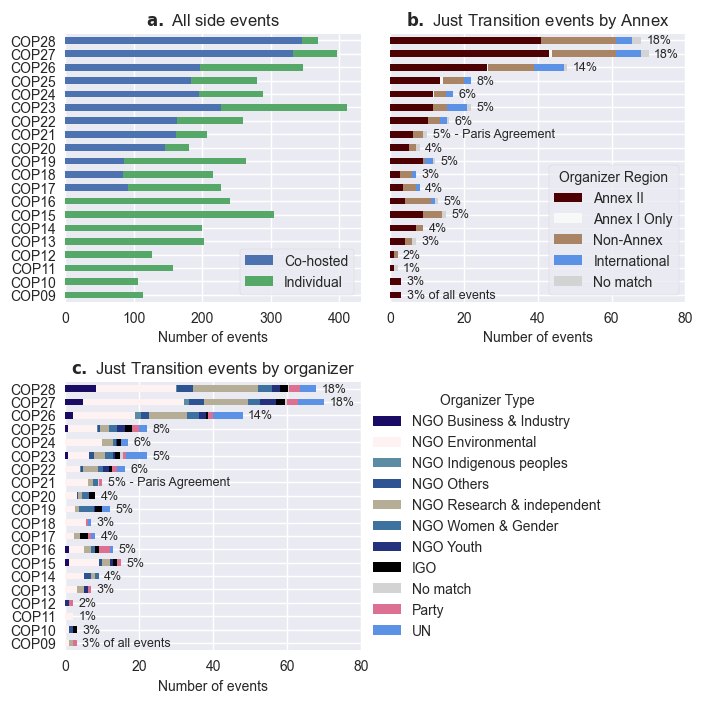

In [49]:
fig, ax = plt.subplots(2,2,figsize=(8,8))#,gridspec_kw={'width_ratios': [1,1,1]})
mpl.style.use('seaborn-v0_8')
fig.subplots_adjust(wspace=0.1,hspace=0.3)

all_COP_data[["Co-hosted","Individual"]].plot(kind='barh', stacked=True,ax = ax[0,0])
ax[0,0].set_ylim([-0.5,len(side_events_sum)-0.5])
#ax[0].set_xlim([0,700])
ax[0,0].set_xlabel("Number of events")
ax[0,0].set_title(r"$\bf{a.}$ All side events",fontsize=12)
ax[0,0].legend(frameon=True)

pivoted_data_country.plot.barh(stacked=True,ax=ax[0,1],#zorder=5,
                               color=[cm.bilbaoS(1),cm.bilbaoS(0),cm.bilbaoS(2),"#5b92e5","lightgray"])
ax[0,1].legend(frameon=True,title="Organizer Region")
ax[0,1].set_ylabel("")
ax[0,1].set_xlim([0,80])
ax[0,1].set(yticklabels=[])  
ax[0,1].set_xlabel("Number of events")
ax[0,1].set_title(r"$\bf{b.}$ Just Transition events by Annex",fontsize=12)


pivoted_data_org.plot.barh(stacked=True,ax=ax[1,0],#zorder=5,
                          color=[cm.lapazS(0),cm.lapazS(1),cm.lapazS(2),cm.lapazS(3),cm.lapazS(4),cm.lapazS(5),cm.lapazS(6),
                                 "black","lightgray","palevioletred","#5b92e5"])
ax[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Organizer Type")
ax[1,0].set_ylabel("")
ax[1,0].set_xlim([0,80])
ax[1,0].set_xlabel("Number of events")
ax[1,0].set_title(r"$\bf{c.}$ Just Transition events by organizer",fontsize=12)

# annotation 
for i in np.arange(len(pivoted_data_country.index)):
    cop = pivoted_data_country.index[i]
    ratio_event = round(pivoted_data_country.loc[cop].sum()/all_COP_data.loc[cop,"all_events"]*100)
    if i == 0:
        str_name = str(ratio_event)+"% of all events"
    elif i == 21-9:
        str_name = str(ratio_event)+"% - Paris Agreement"
    else:
        str_name = str(ratio_event)+"%"
    ax[0,1].text(x=pivoted_data_country.loc[cop].sum()+1.5,y=i-0.25,s=str_name,fontsize=9)
    ax[1,0].text(x=pivoted_data_country.loc[cop].sum()+1.5,y=i-0.25,s=str_name,fontsize=9)

ax[1,1].axis('off')

fig.savefig("affiliation/JT_stats.png",dpi=600, bbox_inches='tight')
fig.savefig("affiliation/JT_stats.pdf")